# Forecasting Vaccination Trends with Time Series Models

In this notebook, I am going to import all of the vaccine data gathered from the four most populous US cities, in the timeframe of 1/1/21-6/15/21. The vaccination data was pulled from each respective city's health department, so all files are slightly different in the information they're supplying. The first part of the notebook focuses on cleaning and inspecting the data before moving on to time series analysis

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import pmdarima as pm

from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
#importing all files
nyc = pd.read_csv('data/nyc.csv')
houston = pd.read_csv('data/Houston.csv')
la = pd.read_csv('data/la.csv')
chicago = pd.read_csv('data/chicago.csv')

## Data Cleaning

After importing all the files, I am going through to make sure each has a consistent format including date range and column name for the target variable. I also am labeling each city within the dataframe for when I merge them. 

In [3]:
# starting with new york

# adding location column
nyc['city'] = 'new york'  

# converting dates to datetime
nyc['date'] = pd.to_datetime(nyc['DATE'])  

# filtering to consistent timeframe
new_nyc = nyc[nyc['date'] >= '2021-01-01'] 

# getting consistent column name for vaccines administered
new_nyc['total_doses'] = new_nyc['ADMIN_ALLDOSES_DAILY']

In [4]:
# repeating steps with houston

houston['date'] = pd.to_datetime(houston['Date_str'])

new_houston = houston[(houston['date'] >= '2021-01-01')
                      & (houston['date'] <= '2021-06-15')]

new_houston['total_doses'] = new_houston['Vaccinated']

# need to do a groupby since there are multiple readings from each date
new_houston = new_houston.groupby(['date'], as_index=False).sum()
new_houston['city'] = 'houston'  # adding location column after groupby

In [5]:
#also need to difference the data as it is cumulative
new_houston['total_doses'] = new_houston['total_doses'].diff()

In [6]:
#chicago
chicago['city'] = 'chicago'
chicago['date'] = pd.to_datetime(chicago['Date'])
chicago['total_doses'] = chicago['Total Doses - Daily']
new_chicago = chicago[chicago['date'] >= '2021-01-01']

In [7]:
#los angeles, also need to group by date
la['date'] = pd.to_datetime(la['Date (Dose 1)'])
new_la = la[la['date'] >= '2021-01-01']
new_la = new_la.groupby(['date'], as_index=False).sum()
new_la['city'] = 'los angeles'
new_la['total_doses'] = new_la['Dose1_all']

I'm writing a function to run each dataframe through to format with only the columns I want. Then I'll look at the data overall.

In [8]:
def to_merge(dataframe):
    city_subset = dataframe[['date', 'city', 'total_doses']]
    return(city_subset)

In [9]:
nyc_merge = to_merge(new_nyc)
houston_merge = to_merge(new_houston)
chicago_merge = to_merge(new_chicago)
la_merge  = to_merge(new_la)

In [10]:
#combining dataframes
combined = pd.concat([nyc_merge, houston_merge, chicago_merge, la_merge],
                     ignore_index=True, sort=False).sort_values(by='date')

time_indexed_combined = combined.set_index('date')

time_indexed_combined.head()

,city,total_doses
date,,
2021-01-01,new york,167.0
2021-01-01,houston,NaN
2021-01-01,los angeles,1112.0
2021-01-01,chicago,48.0
2021-01-02,houston,2737.0


It looks like the overall trend is that the # vaccines per day peaked in April, when most places started making the vaccine available to more of the population. After that, the decline is pretty sharp. In the next section we'll see how this differs (or not) by location)

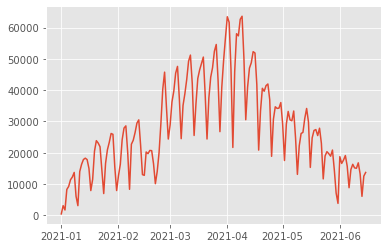

In [11]:
ti_mean = time_indexed_combined.groupby('date').mean()
plt.plot(ti_mean)

## Creating Time Series 

Now that I've cleaned and inspected the data, I'm going to format each city's dataframe for time series modeling.

Looking at the chart below, I can get an idea of how the volume of vaccinations differ from place to place, where New York City is seeing a much higher volume than Houston overall. 

In [12]:
#formatting for time series model
nyc_ts = nyc_merge.set_index('date')['total_doses']
hou_ts = houston_merge.set_index('date')['total_doses']
chi_ts = chicago_merge.set_index('date')['total_doses']
la_ts = la_merge.set_index('date')['total_doses']

In [13]:
#due to the groupby there is 1 null in the houston data
hou_ts = hou_ts.dropna()

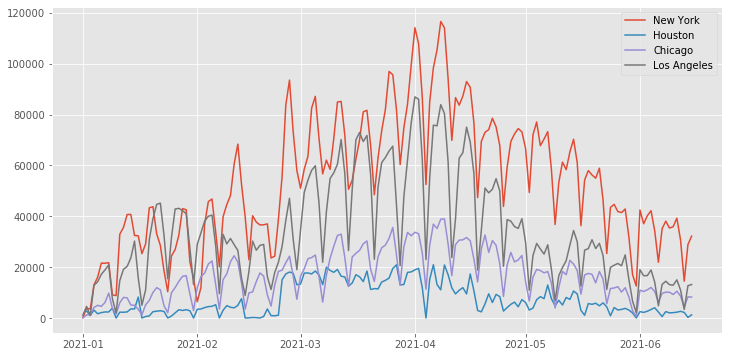

In [14]:
fig = plt.figure(figsize=(12,6))
plt.plot(nyc_ts, label='New York')
plt.plot(hou_ts, label='Houston')
plt.plot(chi_ts, label='Chicago')
plt.plot(la_ts, label='Los Angeles')
plt.legend()

## Checking for Trends

In each city there appear to be periodic trends, which would violate the assumption of stationarity that I'd need for a time series model to be effective. Below I am going to run a test to check if my data is stationary.

The function below will compare the rolling mean and standard deviation of each city for a visual of the trends. Next I'm going to use the Dickey-Fuller test. If the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary.

In [15]:
def stationarity_plot(data, city):
    
    roll_mean = data.rolling(window=7, center=False).mean()
    roll_std = data.rolling(window=7, center=False).std()
    
    dftest = adfuller(data)

    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(city))
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test for {}: \n'.format(city))

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

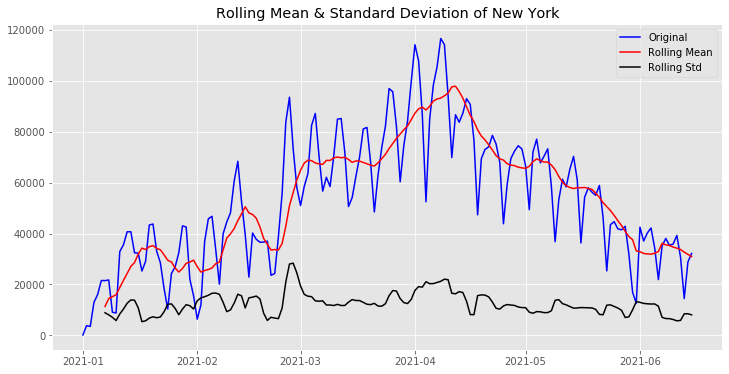

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -1.198953
p-value                          0.674046
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


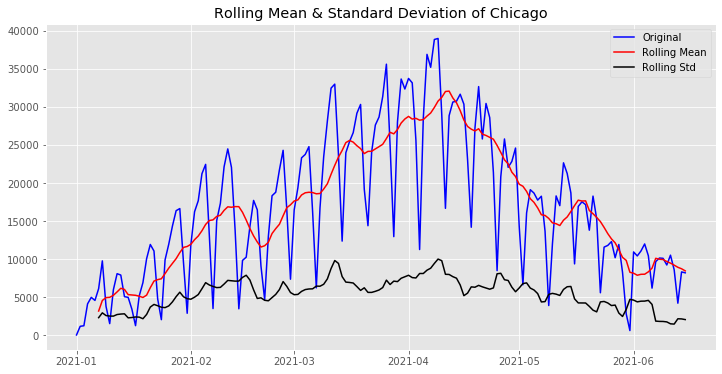

Results of Dickey-Fuller Test for Chicago: 

Test Statistic                  -1.712065
p-value                          0.424907
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


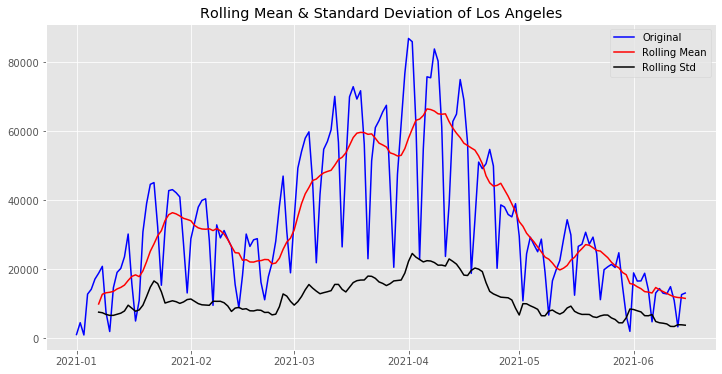

Results of Dickey-Fuller Test for Los Angeles: 

Test Statistic                  -1.547956
p-value                          0.509669
#Lags Used                       8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


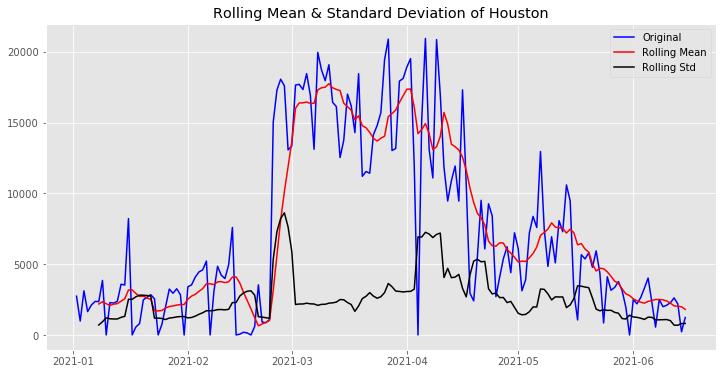

Results of Dickey-Fuller Test for Houston: 

Test Statistic                  -1.540347
p-value                          0.513466
#Lags Used                       7.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [16]:
stationarity_plot(nyc_ts, 'New York')
stationarity_plot(chi_ts, 'Chicago')
stationarity_plot(la_ts, 'Los Angeles')
stationarity_plot(hou_ts, 'Houston')

Results uphold the null hypothesis: the time series is not stationary for any of the cities. So I need to look into removing trends.

To determine the best way to transform the data, I'm going to look at 2 different visuals: log transformations and square root transformations.

## Decomposition

In [17]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(ts):
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

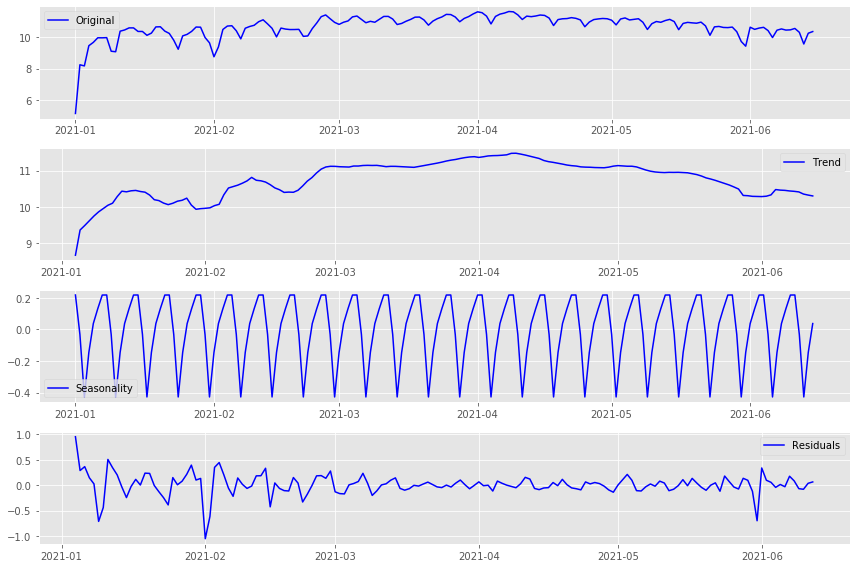

In [18]:
decompose(nyc_ts)

With each time series, there is a trend that increases and levels off in different ways. There is clear seasonality which may have to do with the majority of people receiving their vaccines on weekends. I'll need to remove the seasonality to make sure the time series are stationary. 

To do this, I am going to first log transform each to make the time series more uniform over time. Then, I'll take the rolling mean of each and subtract it from the log transformed time series.

In [19]:
# def detrend(ts):
#     ts_log = np.log(ts)
#     roll_mean = ts_log.rolling(window=7).mean()

#     # Subtract the moving average from the log transformed data
#     data_minus_roll_mean = ts_log - roll_mean

#     # Print the first 10 rows
#     data_minus_roll_mean.dropna(inplace=True)
    
#     fig = plt.figure(figsize=(11,7))
#     plt.plot(data_minus_roll_mean)
#     plt.title('Vaccines with rolling mean subtracted')
#     plt.show(block=False)

In [20]:
# nyc_detrended = detrend(nyc_ts)
# hou_detrended = detrend(hou_ts)
# chi_detrended = detrend(chi_ts)
# la_detrended = detrend(la_ts)

This already looks better so I'm going to check again for stationarity.


It looks like the NYC data has just made it.

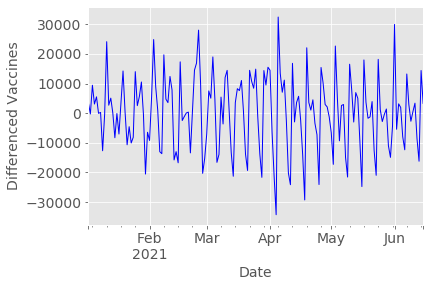

In [21]:
## Differencing
nyc_diff = nyc_ts.diff()
nyc_diff.dropna(inplace=True)
nyc_diff.plot(color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Vaccines', fontsize=14);

In [22]:
# stationarity_plot(nyc_diff, 'New York')

## Checking Correlations

In [23]:
def correlation_plots(df):
    rcParams['figure.figsize'] = 14, 5
    plot_acf(df, lags=50);

    rcParams['figure.figsize'] = 14, 5
    plot_pacf(df, lags=50);

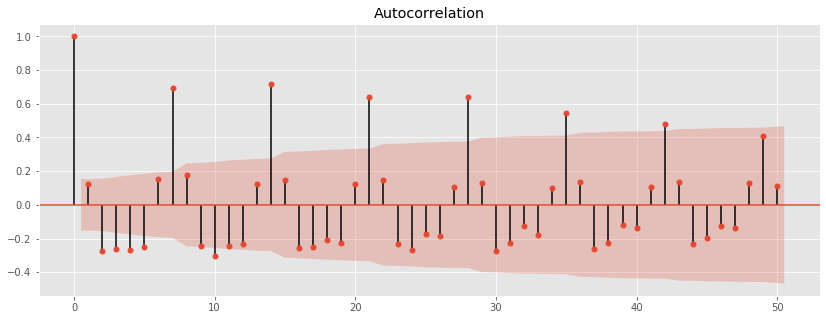

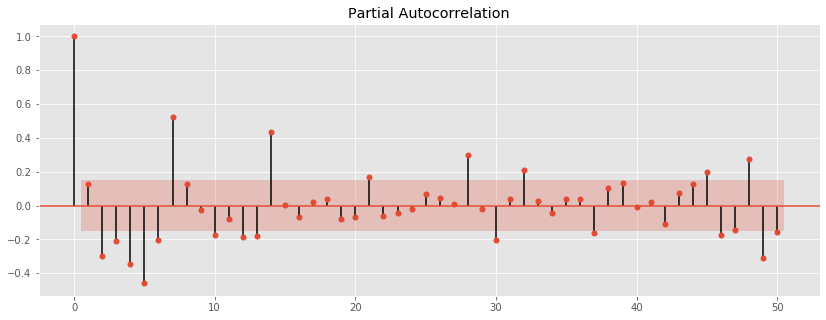

In [24]:
correlation_plots(nyc_diff)

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

## Time Series Modeling

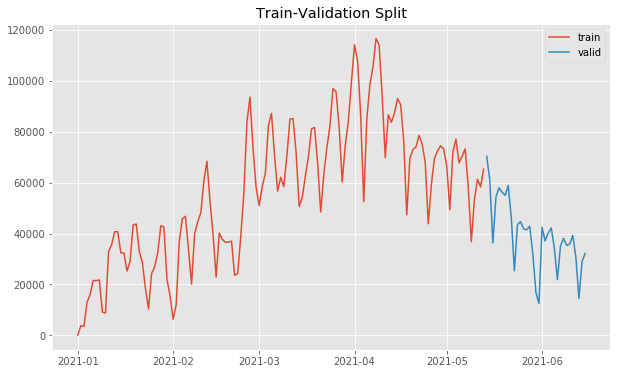

In [25]:
# Define train and test sets according to the index found above
cutoff = round(nyc_ts.shape[0]*0.8)

train = nyc_ts[:cutoff]
valid = nyc_ts[cutoff:]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train, label='train')
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

all featrues have p values > than 0.05 so we can consider them significant

In [26]:
# d=1 since data is not stationary

arima_nyc = pm.auto_arima(train, start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0, 
                      D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=False, error_action='warn', 
                      trace=True, stepwise=True, n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2872.980, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2870.878, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2868.028, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2871.183, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2866.871, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2840.219, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2861.048, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2838.630, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2855.338, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2827.513, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2836.866, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2818.566, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2817.519, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2816.904, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0]          

In [50]:
output = arima_nyc.fit(train)

In [28]:
arima_nyc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1402.452
Date:                Mon, 05 Jul 2021   AIC                           2816.904
Time:                        21:34:57   BIC                           2834.201
Sample:                             0   HQIC                          2823.933
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0787      0.079     -0.993      0.321      -0.234       0.077
ar.L2         -0.4006      0.106     -3.794      0.000      -0.608      -0.194
ar.L3         -0.3020      0.105     -2.876      0.004      -0.508      -0.096
ar.L4         -0.3484      0.111     -3.143      0.002      -0.566      -0.131
ar.L5         -0.3839      0.107     -3.585      0.000      -0.594      -0.174
sigma2      1.002e+08   3.19e-10   3.14e+17      0.000       1e+08       1e+08
===================================================================================
Ljung-Box (Q):                      140.44   Jarque-Bera (JB):                 7.69
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.91   Skew:                             0.03
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.81e+33. Standard errors may be unstable.
"""

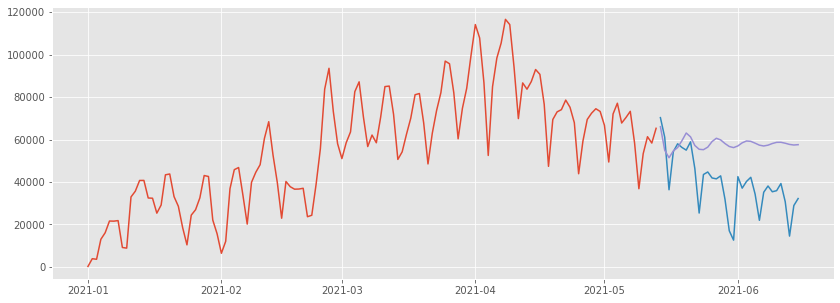

In [36]:
forecast = arima_nyc.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [85]:
rmse = sqrt(mean_squared_error(valid,forecast))
rmse

22205.285462663112

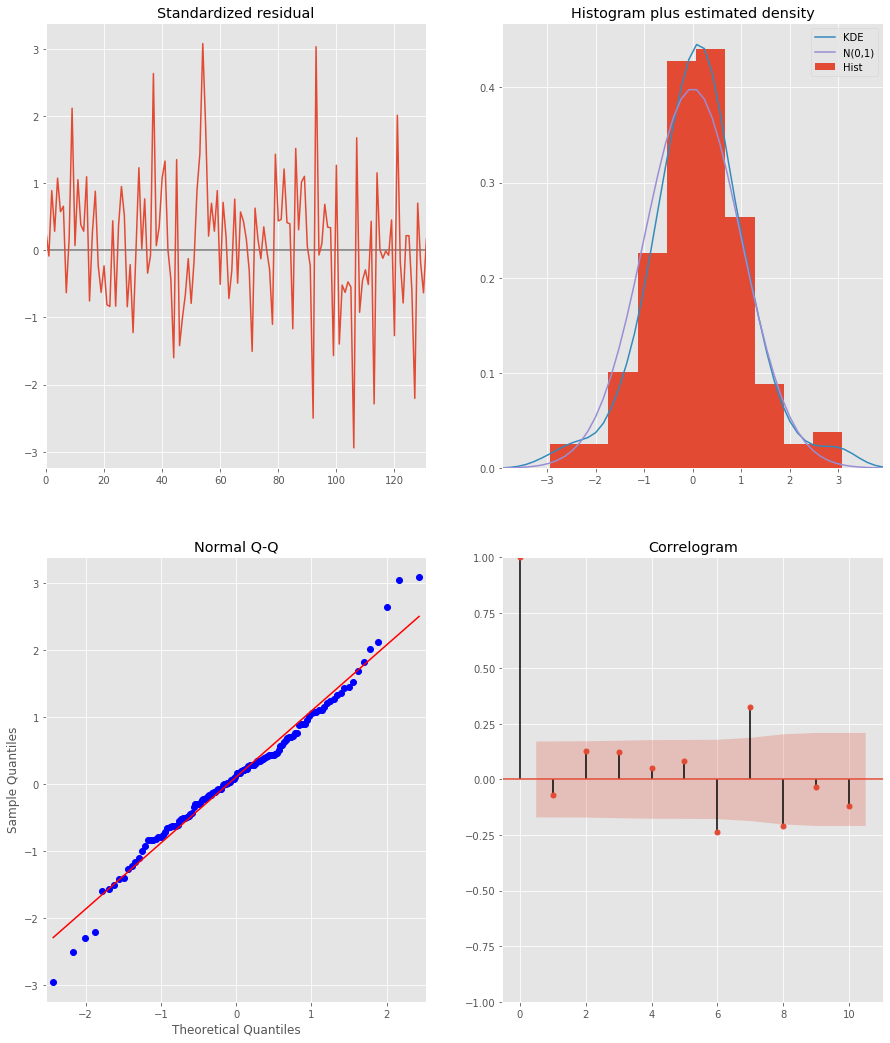

In [86]:
arima_nyc.plot_diagnostics(figsize=(15, 18))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

## Forecasting

In [37]:
pred = arima_nyc.predict(start=pd.to_datetime('2021-06-15'), dynamic=False)

In [47]:
from pmdarima.metrics import smape

model = arima_nyc  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=100, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in valid:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(valid, forecasts)}")
print(f"SMAPE: {smape(valid, forecasts)}")
# Mean squared error: 0.34238951346274243
# SMAPE: 0.9825490519101439

Mean squared error: 143542372.82167327
SMAPE: 23.901605605006576


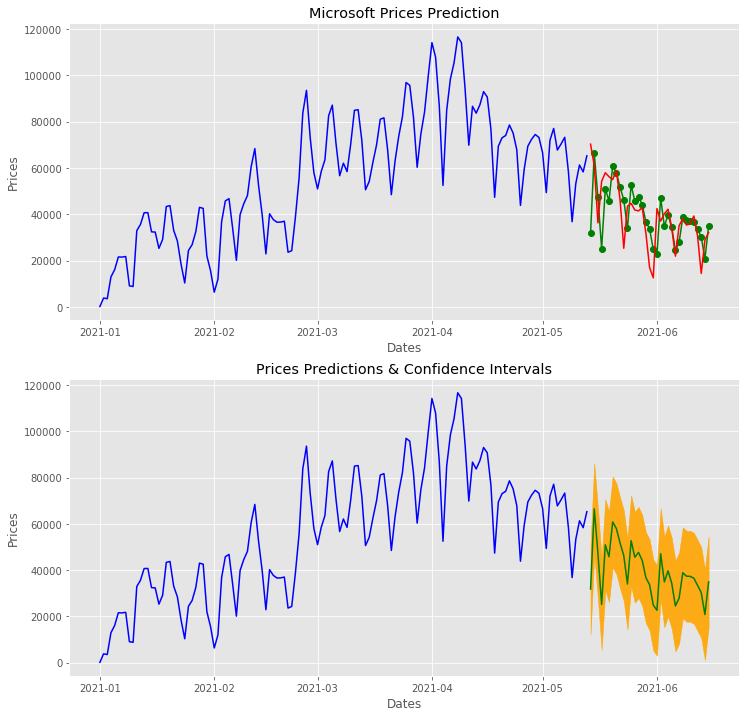

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train, color='blue', label='Training Data')
axes[0].plot(valid.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(valid.index, valid, color='red', label='Actual Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
# axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train, color='blue', label='Training Data')
axes[1].plot(valid.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(valid.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
# axes[1].legend()

https://alkaline-ml.com/pmdarima/usecases/stocks.html

In [52]:
forecast = output.predict(start = len(nyc_ts),
                           end=len(nyc_ts)+24,
                           typ='levels')
                           

In [61]:
plt.plot(nyc_ts, label='Actual')
plt.plot(forecast, label='Forecast')
plt.show()

ValueError: view limit minimum -36897.8 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1008x360 with 1 Axes>